In [14]:
import pandas as pd  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


In [15]:
file_loc = "../Resources/ModelData/model_data.csv"
customer_complaints_df = pd.read_csv(file_loc)
customer_complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7856 entries, 0 to 7855
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       7856 non-null   object
 1   Consumer complaint narrative  7856 non-null   object
dtypes: object(2)
memory usage: 122.9+ KB


In [16]:
# Use a subset of columns for clustering (excluding labels)
clustering_features = customer_complaints_df[["Product", "Consumer complaint narrative"]]

# Encode categorical features and preprocess text
categorical_features = ["Product"]
text_feature = "Consumer complaint narrative"

# Preprocess categorical features using one-hot encoding
categorical_encoded = pd.get_dummies(clustering_features[categorical_features])

# Preprocess text feature using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
text_encoded = tfidf.fit_transform(clustering_features[text_feature])

# Combine encoded features
from scipy.sparse import hstack
combined_features = hstack([categorical_encoded.values, text_encoded])

# Use TruncatedSVD to reduce dimensionality for clustering
svd = TruncatedSVD(n_components=50, random_state=42)
reduced_features = svd.fit_transform(combined_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

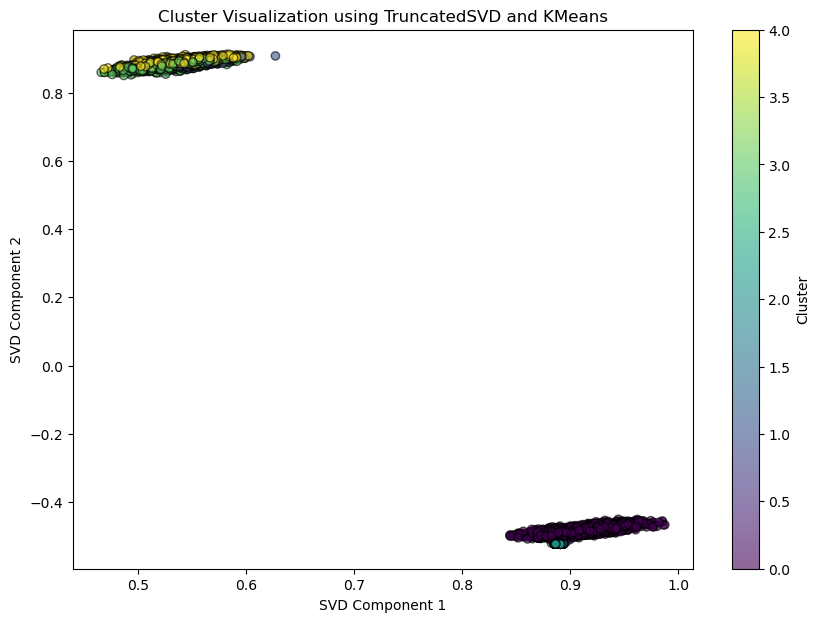

In [17]:
# Visualize clusters using the first two SVD components
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title("Cluster Visualization using TruncatedSVD and KMeans")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.colorbar(label="Cluster")
plt.show()

# # Display cluster distribution
# cluster_counts = pd.Series(clusters).value_counts()
# cluster_counts

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract features and target
X = customer_complaints_df['Consumer complaint narrative']
y = customer_complaints_df['Product']
print(y)
# Preprocess categorical features using one-hot encoding
label_encoder = LabelEncoder()
labels = customer_complaints_df['Product']
y = label_encoder.fit_transform(labels)
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_test)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Use the top 5000 words
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy

0                       Credit card
1       Checking or savings account
2                       Credit card
3                       Credit card
4                       Credit card
                   ...             
7851                    Credit card
7852    Checking or savings account
7853                    Credit card
7854                    Credit card
7855    Checking or savings account
Name: Product, Length: 7856, dtype: object
[1 0 1 ... 1 1 0]
[0 1 0 ... 0 1 0]


0.9173027989821882

In [19]:
# Function to parse classification report
def parse_classification_report(report):
    lines = report.strip().split("\n")
    rows = []
    for line in lines[1:]:  # Skip header
        tokens = line.split()
        if len(tokens) < 2:
            continue  # Skip empty lines or invalid ones
        if tokens[0] in ["accuracy", "macro", "weighted"]:  # Handle summary metrics
            metric_name = " ".join(tokens[:2]) if len(tokens) == 5 else tokens[0]
            metrics = tokens[-3:]
            rows.append([metric_name] + [None] + metrics)
        else:
            label = " ".join(tokens[:-4])
            metrics = tokens[-4:]
            rows.append([label] + metrics)

    return pd.DataFrame(rows, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])

# Convert report to DataFrame
report_df = parse_classification_report(classification_rep)

# Display the DataFrame
print(report_df)

      Class Precision    Recall F1-Score Support
0         0      0.93      0.90     0.92     787
1         1      0.90      0.93     0.92     785
2  accuracy      None  accuracy     0.92    1572
3     macro      None      0.92     0.92    1572
4  weighted      None      0.92     0.92    1572


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.08269720101781171
Mean Squared Error (MSE): 0.08269720101781171
R-squared (R2): 0.6692106604941769


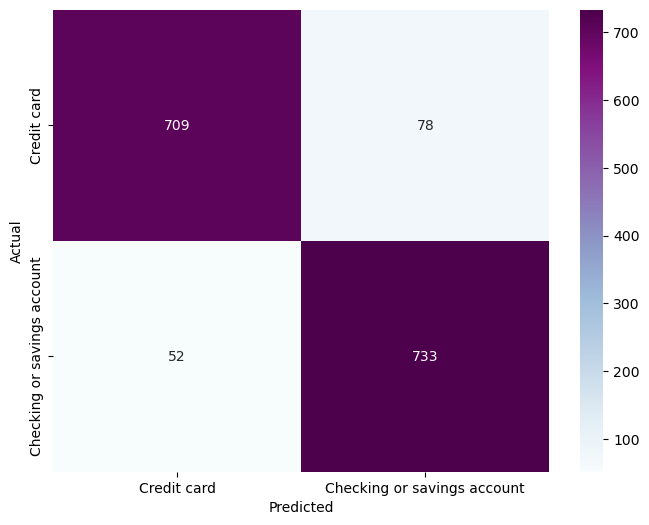

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="BuPu",xticklabels=customer_complaints_df['Product'].unique(),yticklabels=customer_complaints_df['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
import pickle

# Save the model
with open('../Resources/ModelData/supervised_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Model and vectorizer saved with pickle.")

Model and vectorizer saved with pickle.


In [33]:
# Load the model
with open('../Resources/ModelData/supervised_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Load the vectorizer
with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Predict with the loaded model
sample_text = ['''The person opened an account with Capital One on XX/XX/XXXX ; the individual account was current prior to the XXXX pandemic. The global pandemic ( XXXX XXXXXXXX ) hindered the consumer from making payments on time. To ensure the consumer was protected throughout that difficult time, The Cares Act was implemented to prevent lenders from reporting late payments to credit reporting companies during XXXX. The Cares Act did not end until XX/XX/XXXX, but XXXX XXXX was reporting XXXX XXXX XXXX. Under this obligation the credit account was current before the accommodation and the consumer makes the payments pursuant to the accommodation, is not required to make one or more payments pursuant to the accommodation, or the consumer brings the credit account or obligation current. Under FCRA Section 623 ( a ) generally prohibits a person from furnishing inaccurate information to the CRA.''']
sample_tfidf = loaded_vectorizer.transform(sample_text)
predicted_class = loaded_model.predict(sample_tfidf)
print("Predicted class:", predicted_class)

Predicted class: [1]


In [ ]:
from sklearn.svm import SVC

# Train Support Vector Machine (SVM)
svm_model = SVC(probability=True, random_state=42)  # Enable probability for log-loss calculation
svm_model.fit(X_train_tfidf, y_train)

# Predict with SVM
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate SVM
print("=== Support Vector Machine (SVM) Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))


In [34]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict with Random Forest
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest
print("=== Random Forest Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

=== Random Forest Results ===
Accuracy: 0.9173027989821882
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       787
           1       0.91      0.92      0.92       785

    accuracy                           0.92      1572
   macro avg       0.92      0.92      0.92      1572
weighted avg       0.92      0.92      0.92      1572



In [40]:
import pickle

# Save the model
with open('../Resources/ModelData/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Random Forest Model and vectorizer saved with pickle.")

Random Forest Model and vectorizer saved with pickle.


In [41]:
# Load the model
with open('../Resources/ModelData/random_forest_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Load the vectorizer
with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Predict with the loaded model
sample_text = ['Because of my health problems I was unable to pay my bills on time. The bank added 10 late fees for insufficient funds. I asked for reimbursement but was denied. The fees are XXXX XXXX {$35.00} each= {$350.00}']
sample_tfidf = loaded_vectorizer.transform(sample_text)
predicted_class = loaded_model.predict(sample_tfidf)
print("Predicted class:", predicted_class)

Predicted class: [0]
